In [55]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import linear_model as lm
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [56]:
path = '../data/conjoint_survey_results.csv'

In [57]:
data = pd.read_csv(path)

In [58]:
data.head()

,Product,Total
0,Balcony Level<br />\nBack Half<br />\nNo IMAG<...,2
1,Middle Level<br />\nBack Half<br />\nIMAG<br /...,23
2,Middle Level<br />\nBack Half<br />\nNo IMAG<b...,4
3,Middle Level<br />\nFront Half<br />\nNo IMAG<...,7
4,Balcony Level<br />\nBack Half<br />\nNo IMAG<...,2


### Get all unique attributes

We will use these to set the column headers for our dataframe along with a "score" header. The score header will be set to the Total line in the dataframe above ("data"). 

In [59]:
# Getting all unique attributes
all_attributes = set()
for product in data['Product']:
    for attribute in product.split("<br />\n"):
        all_attributes.add(attribute)

In [60]:
all_attributes.add('score')
all_attributes

{'$100',
 '$25',
 '$50',
 '$75',
 '1 hour(s)',
 '2 hour(s)',
 'Back Half',
 'Balcony Level',
 'Floor Level',
 'Front Half',
 'IMAG',
 'Middle Level',
 'No IMAG',
 'Tier 1 Composer',
 'Tier 2 Composer',
 'Tier 3 Composer',
 'score'}

### Initialize the DataFrame

In [61]:
# Create a dataframe with the attributes as the column headers
conjoint_df = pd.DataFrame(columns=all_attributes)

#### Reorder the column headers

In [62]:
col_order = ['score', '$25', '$50', '$75', '$100', 'IMAG', 'No IMAG', 
             '1 hour(s)', '2 hour(s)', 'Back Half', 'Front Half', 
             'Floor Level', 'Middle Level', 'Balcony Level', 
             'Tier 1 Composer', 'Tier 2 Composer', 'Tier 3 Composer']

# Reorder columns:
conjoint_df = conjoint_df[col_order]

In [63]:
conjoint_df

,score,$25,$50,$75,$100,IMAG,No IMAG,1 hour(s),2 hour(s),Back Half,Front Half,Floor Level,Middle Level,Balcony Level,Tier 1 Composer,Tier 2 Composer,Tier 3 Composer


### Append each row as appropriate to the initialized dataframe

We will loop through each row in the original dataframe. Within each loop, we create a new dataframe made up of one row of 17 values all set to 0 with the column headers equal to the column headers set above.

Then we will split the product names for that particular row by "<br />\n" as that is the syntax that the data was exported by. This will result in a list of products for that particular selection, like so:

['$25', 'IMAG', '2 hour(s)', 'Front Half', 'Middle Level', 'Tier 1 Composer']

Next, we filter through each value in that list and set it's value in the newly initialized dataframe as 1 instead of 0. Finally, we set the score in that dataframe equal to the total value provided by that row.

Finally, we append this new dataframe to originally initialized dataframe called "conjoint_df"

In [64]:
for row in np.array(data):
    data_array = pd.DataFrame([[0] * 17], columns=col_order)
    products = row[0].split("<br />\n")
    for product in products:
        data_array[product] = 1
    data_array['score'] = row[1]
    conjoint_df = conjoint_df.append(data_array)

In [65]:
conjoint_df.reset_index(drop=True, inplace=True)

In [66]:
conjoint_df.head()

,score,$25,$50,$75,$100,IMAG,No IMAG,1 hour(s),2 hour(s),Back Half,Front Half,Floor Level,Middle Level,Balcony Level,Tier 1 Composer,Tier 2 Composer,Tier 3 Composer
0,2,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0
1,23,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0
2,4,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0
3,7,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0
4,2,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0


### Set up variables for regression

In [67]:
# Set X equal to all vars except the 'score' column
X = conjoint_df.loc[:, conjoint_df.columns != 'score']

# Provide a constant
# This is to ensure that y takes a non-zero value when all other
#   explanatory variables are set to 0.
X['const'] = 1

# Set y equal to the score
y = conjoint_df.score

In [68]:
regression = sm.OLS(y.astype(float), X.astype(float)).fit()

In [69]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     4.714
Date:                Wed, 07 Aug 2019   Prob (F-statistic):            0.00135
Time:                        10:40:06   Log-Likelihood:                -87.784
No. Observations:                  32   AIC:                             197.6
Df Residuals:                      21   BIC:                             213.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
$25                 7.0568      2.007      3.516      0.002       2.883      11.231
$50                 2.1886      1.792      1.222      0.235      -1.537       5.914
$75                -2.2707      1.474     -1.541      0.138      -5.336       0.794
$100               -4.0420      1.464     -2.761      0.012      -7.086      -0.998
IMAG                4.9347      1.072      4.604      0.000       2.706       7.164
No IMAG            -2.0019      1.033     -1.938      0.066      -4.151       0.147
1 hour(s)          -0.2993      1.008     -0.297      0.769      -2.396       1.797
2 hour(s)           3.2320      0.993      3.255      0.004       1.167       5.297
Back Half           0.9696      0.949      1.022      0.319      -1.004       2.943
Front Half          1.9632      0.971      2.021      0.056      -0.057       3.983
Floor Level         2.4095      1.598      1.508      0.147      -0.914       5.733
Middle Level       -0.4112      1.211     -0.340      0.738      -2.929       2.107
Balcony Level       0.9344      1.536      0.608      0.549      -2.259       4.128
Tier 1 Composer     2.3499      1.491      1.576      0.130      -0.751       5.451
Tier 2 Composer     2.5013      1.364      1.834      0.081      -0.335       5.338
Tier 3 Composer    -1.9185      1.301     -1.475      0.155      -4.624       0.787
const               2.9327      0.257     11.414      0.000       2.398       3.467
==============================================================================
Omnibus:                        0.210   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.900   Jarque-Bera (JB):                0.058
Skew:                          -0.095   Prob(JB):                        0.972
Kurtosis:                       2.916   Cond. No.                     6.27e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Visualize the Results

In [70]:
# Color formatting
color_dict = {
    '$25': "forestgreen", 
    '$50': "forestgreen", 
    '$75': "forestgreen", 
    '$100': "forestgreen", 
    'IMAG': "darkcyan", 
    'No IMAG': "darkcyan",
    '1 hour(s)': "firebrick",
    '2 hour(s)': "firebrick", 
    'Back Half': "darkkhaki", 
    'Front Half': "darkkhaki", 
    'Floor Level': "darkslateblue", 
    'Middle Level': "darkslateblue", 
    'Balcony Level': "darkslateblue", 
    'Tier 1 Composer': "sienna", 
    'Tier 2 Composer': "sienna", 
    'Tier 3 Composer': "sienna"
}

#### Top 4 attribute impact

In [71]:
att_imp_df = pd.DataFrame(data=abs(regression.params), columns=["coeff"], index=X.columns)
att_imp_df.sort_values(by=["coeff"], ascending=False, inplace=True)

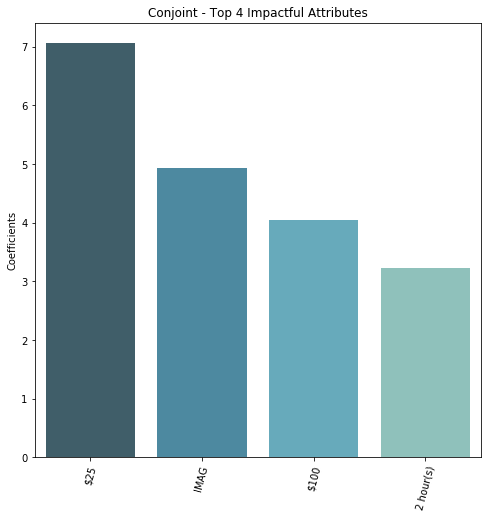

In [72]:
# Plot setup
plt.figure(figsize=[8,8])

# Plotting data
sns.barplot(data=att_imp_df.transpose().drop(columns=['const']).iloc[:, :4], palette="GnBu_d")


# Plotting formatting
plt.title('Conjoint - Top 4 Impactful Attributes')
plt.ylabel('Coefficients')
plt.xticks(rotation=75)
plt.show()

#### Conjoint Attribution plot

In [73]:
attribution_df = pd.DataFrame(data=[regression.params], columns=X.columns)

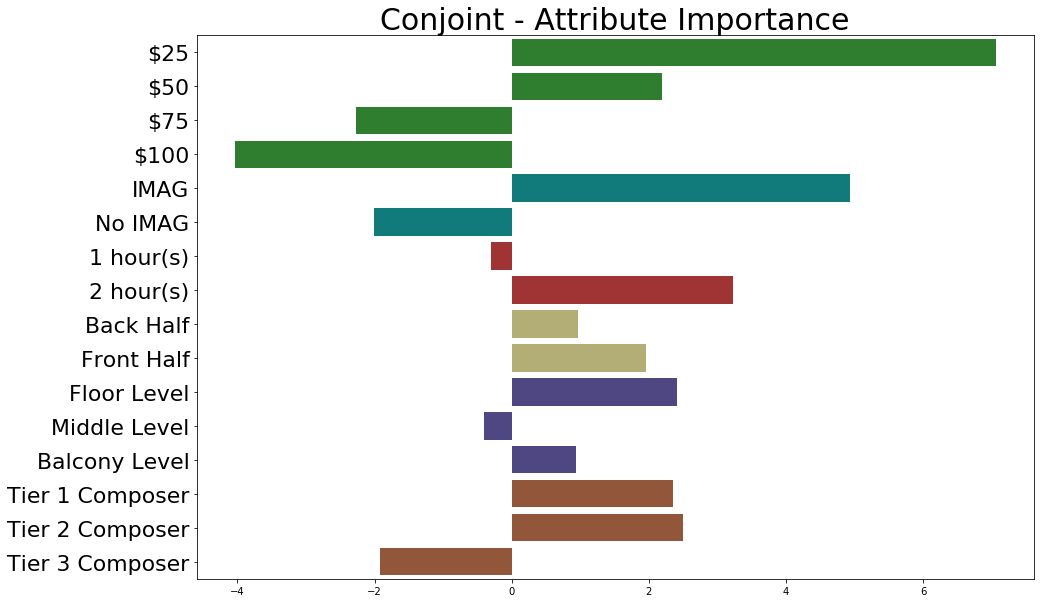

In [94]:
# Plot setup
plt.figure(figsize=[15,10])

# Plotting data
sns.barplot(data=attribution_df.drop(columns=['const']),
           orient="h", palette=color_dict)

# Plotting formatting
plt.title('Conjoint - Attribute Importance', fontsize=30)
plt.rc('ytick',labelsize=18)
plt.show()

# The next step is rerunning everything but based on gender differences

This will not be recording or documenting steps along the way and will simply output the regression summary and plots.

All variables will be prepended with "g" to represent gender and appended with "_m" or "_f" as necessary to represent male and female.

In [20]:
g_path = '../data/conjoint_survey_results_gender.csv'

g_data = pd.read_csv(g_path)

g_all_attributes = set()
for product in g_data['Product']:
    for attribute in product.split("<br />\n"):
        g_all_attributes.add(attribute)
        
g_all_attributes.add('score')

g_conjoint_df = pd.DataFrame(columns=g_all_attributes)

g_col_order = ['score', '$25', '$50', '$75', '$100', 'IMAG', 'No IMAG', 
             '1 hour(s)', '2 hour(s)', 'Back Half', 'Front Half', 
             'Floor Level', 'Middle Level', 'Balcony Level', 
             'Tier 1 Composer', 'Tier 2 Composer', 'Tier 3 Composer']
g_conjoint_df = g_conjoint_df[g_col_order] 

# Create a male and female copy
g_conjoint_df_f = g_conjoint_df.copy()
g_conjoint_df_m = g_conjoint_df.copy()

for row in np.array(g_data):
    g_data_array = pd.DataFrame([[0] * 17], columns=g_col_order)
    products = row[0].split("<br />\n")
    for product in products:
        g_data_array[product] = 1
    
    # First set female score
    g_data_array['score'] = row[1]
    g_conjoint_df_f = g_conjoint_df_f.append(g_data_array)
    
    # Then set male score
    g_data_array['score'] = row[2]
    g_conjoint_df_m = g_conjoint_df_m.append(g_data_array)
    
g_conjoint_df_f.reset_index(drop=True, inplace=True)
g_conjoint_df_m.reset_index(drop=True, inplace=True)


# Set X equal to all vars except the 'score' column
X_f = g_conjoint_df_f.loc[:, g_conjoint_df_f.columns != 'score']
X_m = g_conjoint_df_m.loc[:, g_conjoint_df_m.columns != 'score']

# Provide a constant
# This is to ensure that y takes a non-zero value when all other
#   explanatory variables are set to 0.
X_f['const'] = 1
X_m['const'] = 1

# Set y equal to the score
y_f = g_conjoint_df_f.score
y_m = g_conjoint_df_m.score


regression_f = sm.OLS(y_f.astype(float), X_f.astype(float)).fit()
regression_m = sm.OLS(y_m.astype(float), X_m.astype(float)).fit()

### Female Summary Output

In [21]:
regression_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     4.979
Date:                Wed, 07 Aug 2019   Prob (F-statistic):           0.000959
Time:                        10:17:59   Log-Likelihood:                -63.013
No. Observations:                  32   AIC:                             148.0
Df Residuals:                      21   BIC:                             164.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
$25                 2.1126      0.925      2.283      0.033       0.188       4.037
$50                 1.0370      0.826      1.255      0.223      -0.681       2.755
$75                -0.1741      0.680     -0.256      0.800      -1.588       1.239
$100               -1.7575      0.675     -2.604      0.017      -3.161      -0.354
IMAG                1.9665      0.494      3.979      0.001       0.939       2.994
No IMAG            -0.7487      0.476     -1.571      0.131      -1.739       0.242
1 hour(s)          -0.3294      0.465     -0.709      0.486      -1.296       0.637
2 hour(s)           1.5473      0.458      3.380      0.003       0.595       2.499
Back Half           0.6127      0.438      1.400      0.176      -0.297       1.523
Front Half          0.6052      0.448      1.351      0.191      -0.326       1.537
Floor Level         1.8662      0.737      2.532      0.019       0.334       3.399
Middle Level       -0.1966      0.558     -0.352      0.728      -1.358       0.964
Balcony Level      -0.4517      0.708     -0.638      0.530      -1.924       1.021
Tier 1 Composer     1.1025      0.688      1.603      0.124      -0.327       2.532
Tier 2 Composer     0.9747      0.629      1.550      0.136      -0.333       2.283
Tier 3 Composer    -0.8593      0.600     -1.432      0.167      -2.107       0.388
const               1.2179      0.118     10.279      0.000       0.971       1.464
==============================================================================
Omnibus:                        5.360   Durbin-Watson:                   2.487
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                1.876
Skew:                          -0.098   Prob(JB):                        0.391
Kurtosis:                       1.830   Cond. No.                     6.27e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Male summary output

In [23]:
regression_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     3.547
Date:                Wed, 07 Aug 2019   Prob (F-statistic):            0.00697
Time:                        10:18:37   Log-Likelihood:                -72.209
No. Observations:                  32   AIC:                             166.4
Df Residuals:                      21   BIC:                             182.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
$25                 4.5735      1.234      3.708      0.001       2.008       7.139
$50                 1.0014      1.101      0.909      0.373      -1.289       3.291
$75                -1.8215      0.906     -2.011      0.057      -3.705       0.062
$100               -2.1367      0.900     -2.375      0.027      -4.008      -0.266
IMAG                2.6970      0.659      4.094      0.001       1.327       4.067
No IMAG            -1.0804      0.635     -1.701      0.104      -2.401       0.240
1 hour(s)          -0.0921      0.620     -0.149      0.883      -1.381       1.196
2 hour(s)           1.7088      0.610      2.800      0.011       0.440       2.978
Back Half           0.2863      0.583      0.491      0.629      -0.927       1.499
Front Half          1.3303      0.597      2.229      0.037       0.089       2.572
Floor Level         0.6058      0.982      0.617      0.544      -1.437       2.648
Middle Level       -0.2069      0.744     -0.278      0.784      -1.754       1.341
Balcony Level       1.2178      0.944      1.290      0.211      -0.745       3.181
Tier 1 Composer     0.9964      0.916      1.087      0.289      -0.909       2.902
Tier 2 Composer     1.4679      0.838      1.751      0.095      -0.275       3.211
Tier 3 Composer    -0.8477      0.800     -1.060      0.301      -2.511       0.815
const               1.6167      0.158     10.237      0.000       1.288       1.945
==============================================================================
Omnibus:                        0.710   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.105
Skew:                          -0.061   Prob(JB):                        0.949
Kurtosis:                       3.252   Cond. No.                     6.27e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

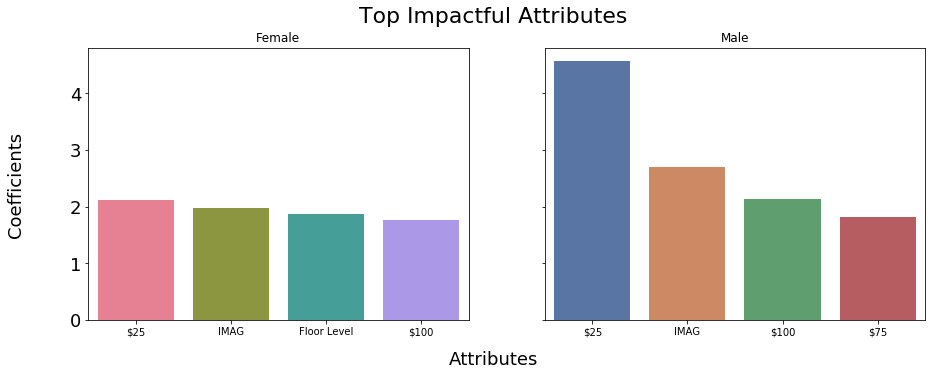

In [95]:
att_imp_df_f = pd.DataFrame(data=abs(regression_f.params), columns=["coeff"], index=X_f.columns)
att_imp_df_f.sort_values(by=["coeff"], ascending=False, inplace=True)

att_imp_df_m = pd.DataFrame(data=abs(regression_m.params), columns=["coeff"], index=X_m.columns)
att_imp_df_m.sort_values(by=["coeff"], ascending=False, inplace=True)


# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5], sharey=True)

# Plotting data
sns.barplot(data=att_imp_df_f.transpose().drop(columns=['const']).iloc[:, :4], palette="husl", ax=ax1)
sns.barplot(data=att_imp_df_m.transpose().drop(columns=['const']).iloc[:, :4], palette="deep", ax=ax2)


# Plotting formatting
ax1.title.set_text('Female')
ax2.title.set_text('Male')

fig.text(0.5, 0.95, 'Top Impactful Attributes', ha='center', fontsize=22)
fig.text(0.5, 0, 'Attributes', ha='center', fontsize=18)
fig.text(0.05, 0.5, 'Coefficients', va='center', rotation='vertical', fontsize=18)

plt.show()


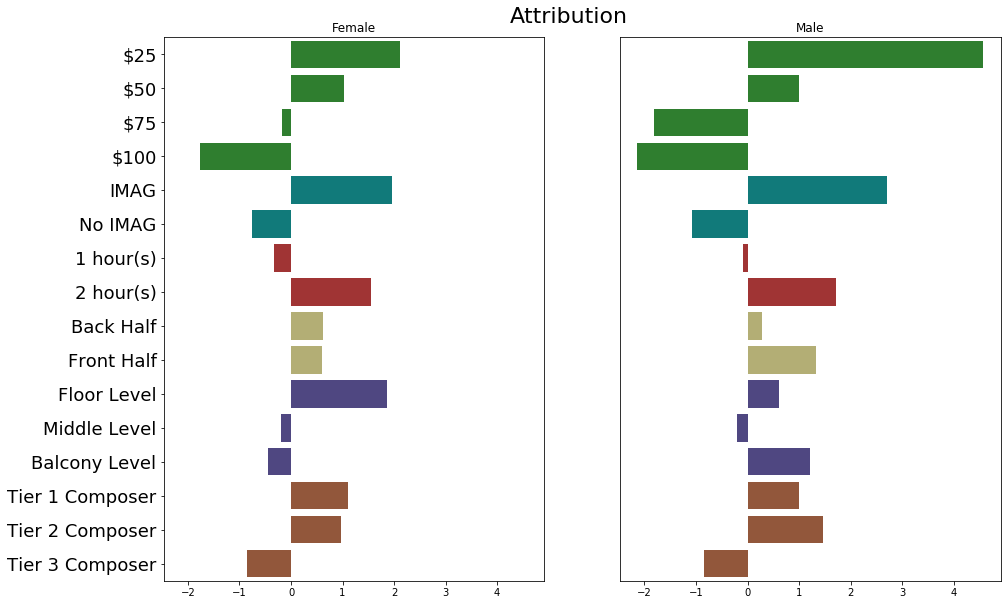

In [99]:
# Color formatting
g_color_dict = {
    '$25': "forestgreen", 
    '$50': "forestgreen", 
    '$75': "forestgreen", 
    '$100': "forestgreen", 
    'IMAG': "darkcyan", 
    'No IMAG': "darkcyan",
    '1 hour(s)': "firebrick",
    '2 hour(s)': "firebrick", 
    'Back Half': "darkkhaki", 
    'Front Half': "darkkhaki", 
    'Floor Level': "darkslateblue", 
    'Middle Level': "darkslateblue", 
    'Balcony Level': "darkslateblue", 
    'Tier 1 Composer': "sienna", 
    'Tier 2 Composer': "sienna", 
    'Tier 3 Composer': "sienna"
}


attribution_df_f = pd.DataFrame(data=[regression_f.params], columns=X_f.columns)
attribution_df_m = pd.DataFrame(data=[regression_m.params], columns=X_m.columns)


# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,10], sharex=True)

# Plotting data
sns.barplot(data=attribution_df_f.drop(columns=['const']),
           orient="h", palette=color_dict, ax=ax1)
sns.barplot(data=attribution_df_m.drop(columns=['const']),
           orient="h", palette=color_dict, ax=ax2)


# Plotting formatting
ax1.title.set_text('Female')
ax2.title.set_text('Male')

fig.text(0.5, 0.9, 'Attribution', ha='center', fontsize=22)

ax2.yaxis.set_ticks([])

plt.rc('ytick',labelsize=18)
plt.show()